# unsuccessful tries (oversimplified)

 88%|████████▊ | 440/500 [00:00<00:00, 40018.51it/s]


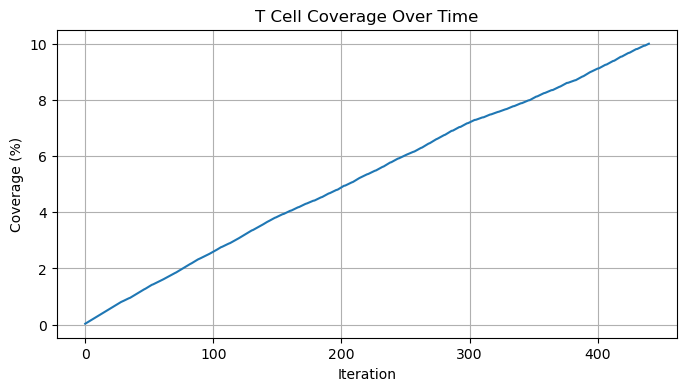

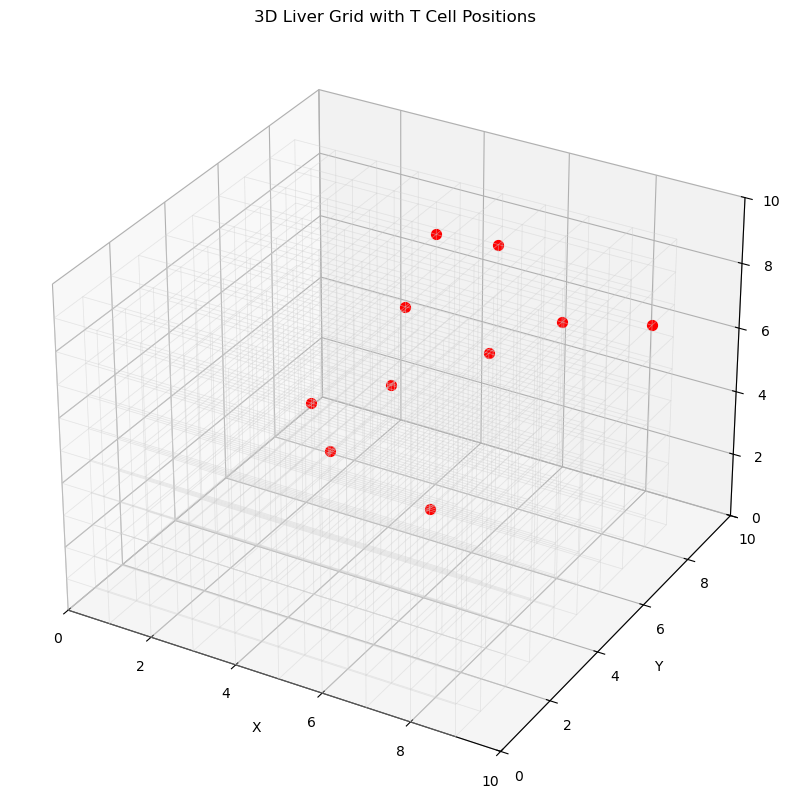

In [1]:
# Re-import necessary modules due to kernel reset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Constants
LIVER_LENGTH_CM = 1.0 
JUNCTION_SPACING_UM = 50
INTERVALS_PER_SEGMENT = 4
STEP_SIZE_UM = JUNCTION_SPACING_UM / (INTERVALS_PER_SEGMENT + 1)
DIFFUSION_COEFFICIENT = (25 / 6) * np.pi

# Reduced grid for visualization
vertices_per_edge = 10
total_vertices = vertices_per_edge ** 3
directions = [(-1,0,0), (1,0,0), (0,-1,0), (0,1,0), (0,0,-1), (0,0,1)]
direction_ids = {d: i for i, d in enumerate(directions)}
num_directions = len(directions)
locations_per_segment = INTERVALS_PER_SEGMENT + 2
total_locations = total_vertices * num_directions * locations_per_segment

class TCell:
    def __init__(self, vertex, direction=None, position=0):
        self.vertex = vertex
        self.direction = direction
        self.position = position

class LiverModelEdge:
    def __init__(self):
        self.graph = self._build_graph()
        self.visited = np.zeros(total_locations, dtype=bool)

    def _xyz_to_index(self, x, y, z):
        return x + y * vertices_per_edge + z * vertices_per_edge**2

    def _index_to_xyz(self, idx):
        z = idx // (vertices_per_edge ** 2)
        y = (idx % (vertices_per_edge ** 2)) // vertices_per_edge
        x = idx % vertices_per_edge
        return x, y, z

    def _get_location_index(self, vertex_idx, direction, position):
        direction_id = direction_ids.get(direction, 0)
        return vertex_idx * num_directions * locations_per_segment + direction_id * locations_per_segment + position

    def _build_graph(self):
        graph = {}
        for x in range(vertices_per_edge):
            for y in range(vertices_per_edge):
                for z in range(vertices_per_edge):
                    idx = self._xyz_to_index(x, y, z)
                    graph[idx] = []
                    for dx, dy, dz in directions:
                        nx, ny, nz = x + dx, y + dy, z + dz
                        if 0 <= nx < vertices_per_edge and 0 <= ny < vertices_per_edge and 0 <= nz < vertices_per_edge:
                            neighbor_idx = self._xyz_to_index(nx, ny, nz)
                            graph[idx].append((neighbor_idx, (dx, dy, dz)))
        return graph

    def simulate(self, M_cells, p_percent, max_iter=1000):
        cells = [TCell(np.random.randint(0, total_vertices)) for _ in range(M_cells)]
        coverage_values = []

        for t in tqdm(range(max_iter)):
            for cell in cells:
                if cell.position == 0:
                    neighbors = self.graph[cell.vertex]
                    if neighbors:
                        target, direction = neighbors[np.random.randint(len(neighbors))]
                        cell.direction = direction
                        cell.position = 1
                elif cell.position < INTERVALS_PER_SEGMENT + 1:
                    cell.position += 1
                else:
                    dx, dy, dz = cell.direction
                    x, y, z = self._index_to_xyz(cell.vertex)
                    nx, ny, nz = x + dx, y + dy, z + dz
                    cell.vertex = self._xyz_to_index(nx, ny, nz)
                    cell.direction = None
                    cell.position = 0

                loc_idx = self._get_location_index(cell.vertex, cell.direction, cell.position)
                self.visited[loc_idx] = True

            coverage = np.mean(self.visited) * 100
            coverage_values.append(coverage)
            if coverage >= p_percent:
                break

        time_elapsed = t * (STEP_SIZE_UM**2) / (2 * DIFFUSION_COEFFICIENT)
        return time_elapsed, coverage_values, cells

# Run simulation
model = LiverModelEdge()
time_elapsed, coverage_values, cells = model.simulate(M_cells=10, p_percent=10, max_iter=500)

# Plot coverage over time
plt.figure(figsize=(8, 4))
plt.plot(coverage_values)
plt.xlabel('Iteration')
plt.ylabel('Coverage (%)')
plt.title('T Cell Coverage Over Time')
plt.grid(True)
plt.show()

# Grid and cell visualization
def visualize_grid_and_cells(model, cells):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('3D Liver Grid with T Cell Positions')
    ax.set_xlim(0, vertices_per_edge)
    ax.set_ylim(0, vertices_per_edge)
    ax.set_zlim(0, vertices_per_edge)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Draw grid edges
    edges = []
    for idx, neighbors in model.graph.items():
        x0, y0, z0 = model._index_to_xyz(idx)
        for neighbor_idx, _ in neighbors:
            x1, y1, z1 = model._index_to_xyz(neighbor_idx)
            edges.append([(x0, y0, z0), (x1, y1, z1)])

    edge_collection = Line3DCollection(edges, colors='lightgrey', linewidths=0.5, alpha=0.3)
    ax.add_collection3d(edge_collection)

    # Plot T cell positions
    for cell in cells:
        x, y, z = model._index_to_xyz(cell.vertex)
        ax.scatter(x, y, z, color='red', s=50)

    plt.show()

# Visualize the liver grid and cells
visualize_grid_and_cells(model, cells)


In [2]:
# Run simulation with 1,000,000 
large_M_cells = 1_000_000 
target_coverage = 90
max_iterations = 10000  # Can increase if needed

# Initialize new model to avoid carry-over of visited state
model_large = LiverModelEdge()
time_large, coverage_values_large, cells_large = model_large.simulate(
    M_cells=large_M_cells,
    p_percent=target_coverage,
    max_iter=max_iterations
)

# Output result
time_large_hours = time_large / 60  # Convert from minutes to hours
time_large_hours

100%|██████████| 10000/10000 [1:13:56<00:00,  2.25it/s]


636.5561103903445

  1%|          | 8/1000 [02:09<4:27:28, 16.18s/it]

Time to reach 99% coverage with 2.5 million cells: 0.57 hours


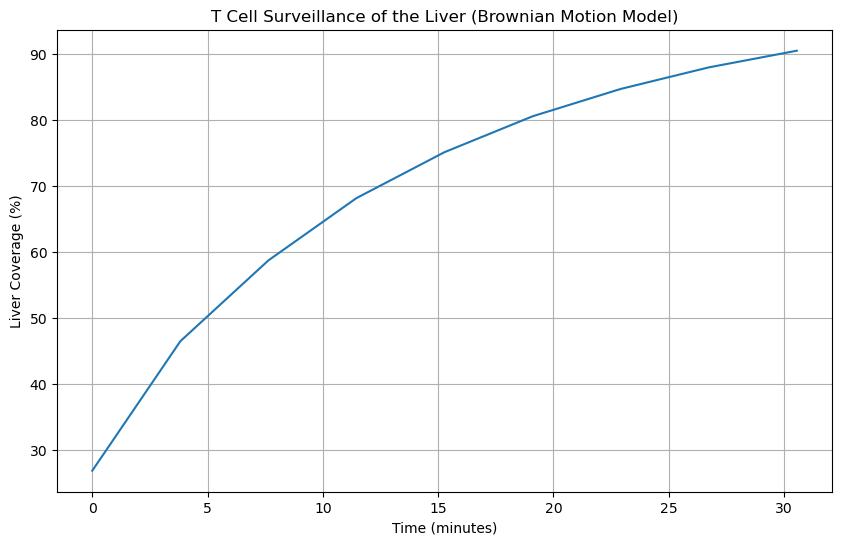

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Constants 
LIVER_LENGTH_CM = 1.0  # 1 cm³ liver
JUNCTION_SPACING_UM = 50  # 50 µm between sinusoid junctions
AVG_TCELL_SPEED_UM_MIN = 10  # 10 µm/min
DIFFUSION_COEFFICIENT = (25 / 6) * np.pi  # µm²/min
TIME_PER_ITERATION_MIN = 12 / np.pi  # ~3.82 min per iteration

# Discretization for computational efficiency
DISCRETIZATION_STEP_UM = 10  # 10 µm steps (as in the paper)
INTERVALS_PER_SEGMENT = int(JUNCTION_SPACING_UM / DISCRETIZATION_STEP_UM) - 1

# Liver dimensions (in grid units)
GRID_SIZE = int(LIVER_LENGTH_CM * 1e4 / JUNCTION_SPACING_UM)  # around 200 for 1 cm liver
TOTAL_VERTICES = GRID_SIZE ** 3  # aroudn 8 million junctions (too large, so we reduce for demo)

# For demonstration, use a smaller grid 
# DEMO_GRID_SIZE = 20
# DEMO_TOTAL_VERTICES = DEMO_GRID_SIZE ** 3
 
class LiverModel:
    def __init__(self):
        self.graph = self._build_3d_grid()
        self.visited = np.zeros(TOTAL_VERTICES, dtype=bool)
        self.time_elapsed_min = 0

    def _build_3d_grid(self):
        """Constructs a 3D grid representing liver sinusoids."""
        grid = {}
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                for z in range(GRID_SIZE):
                    idx = x + y * GRID_SIZE + z * GRID_SIZE ** 2
                    grid[idx] = []
                    # Define 6 possible directions (3D grid)
                    for dx, dy, dz in [(-1,0,0), (1,0,0), (0,-1,0), (0,1,0), (0,0,-1), (0,0,1)]:
                        nx, ny, nz = x + dx, y + dy, z + dz
                        if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and 0 <= nz < GRID_SIZE:
                            neighbor_idx = nx + ny * GRID_SIZE + nz * GRID_SIZE ** 2
                            grid[idx].append(neighbor_idx)
        return grid

    def simulate_coverage(self, num_tcells, target_coverage_percent=90, max_iter=1000):
        """Simulates T cell movement and calculates coverage time."""
        # Initialize T cells at random positions
        tcells = np.random.randint(0, TOTAL_VERTICES, size=num_tcells)
        coverage_history = []

        for _ in tqdm(range(max_iter)):
            # Move each T cell to a random neighbor- Brownian motion approx
            for i in range(num_tcells):
                current_pos = tcells[i]
                neighbors = self.graph[current_pos]
                if neighbors:
                    tcells[i] = np.random.choice(neighbors)
                    self.visited[tcells[i]] = True

            # Update coverage
            coverage = np.mean(self.visited) * 100
            coverage_history.append(coverage)
            self.time_elapsed_min += TIME_PER_ITERATION_MIN

            # Stop if target coverage is reached
            if coverage >= target_coverage_percent:
                break

        return coverage_history, self.time_elapsed_min

    def plot_coverage(self, coverage_history):
        """Plots coverage over time."""
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(len(coverage_history)) * TIME_PER_ITERATION_MIN, coverage_history)
        plt.xlabel("Time (minutes)")
        plt.ylabel("Liver Coverage (%)")
        plt.title("T Cell Surveillance of the Liver (Brownian Motion Model)")
        plt.grid(True)
        plt.show()

# Run simulation
model = LiverModel()
coverage_history, total_time = model.simulate_coverage(num_tcells=2500000, target_coverage_percent=90)
print(f"Time to reach 90% coverage with 2.5 million cells: {total_time/60:.2f} hours")

# Plot results
model.plot_coverage(coverage_history)

# complex model takes forever - implemented in c++ ot use gpu

In [ ]:
#Actual unsimplified model takes forever- implemented in c++ for gpu opt
# import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

# Constants (from the paper)
LIVER_LENGTH_CM = 1.0  # 1 cm³ liver
JUNCTION_SPACING_UM = 50  # 50 µm between sinusoid junctions
AVG_TCELL_SPEED_UM_MIN = 10  # 10 µm/min
DIFFUSION_COEFFICIENT = (25 / 6) * np.pi  # µm²/min
TIME_STEP_MIN = 0.1  # Smaller time steps for smoother motion

# Simulation parameters
GRID_SIZE = 200  # Matches paper's 1cm liver with 50µm spacing
GRID_SPACING_UM = LIVER_LENGTH_CM * 1e4 / GRID_SIZE  # µm per grid unit
NUM_TCELLS = 2500000  

class LiverModelContinuous:
    def __init__(self):
        self.grid_size = GRID_SIZE
        self.grid_spacing = GRID_SPACING_UM
        self.visited = np.zeros((GRID_SIZE, GRID_SIZE, GRID_SIZE), dtype=bool)
        self.time_elapsed_min = 0

    def _initialize_tcells(self, num_tcells):
        """Initialize T cells at random positions in continuous 3D space."""
        return np.random.rand(num_tcells, 3) * self.grid_size

    def _get_nearest_junction(self, pos):
        """Snap to the nearest sinusoid junction (grid point)."""
        return np.clip(np.round(pos).astype(int), 0, self.grid_size-1)

    def _brownian_motion_step(self, pos):
        """Generate a Brownian motion step (Wiener process)."""
        step_size_um = np.sqrt(2 * DIFFUSION_COEFFICIENT * TIME_STEP_MIN)
        displacement = norm.rvs(scale=step_size_um, size=3) / self.grid_spacing
        new_pos = pos + displacement
        return np.clip(new_pos, 0, self.grid_size - 1e-6)

    def simulate_coverage(self, num_tcells, target_coverage_percent=99, max_steps=1000):
        """Simulate T cell motion and compute coverage."""
        tcells = self._initialize_tcells(num_tcells)
        coverage_history = []

        for _ in tqdm(range(max_steps)):
            # Update T cell positions (Brownian motion)
            for i in range(num_tcells):
                tcells[i] = self._brownian_motion_step(tcells[i])
                # Mark visited junctions
                junction = self._get_nearest_junction(tcells[i])
                self.visited[tuple(junction)] = True

            # Update coverage
            coverage = np.mean(self.visited) * 100
            coverage_history.append(coverage)
            self.time_elapsed_min += TIME_STEP_MIN

            # Stop if target coverage is reached
            if coverage >= target_coverage_percent:
                break

        return coverage_history, self.time_elapsed_min

    def plot_coverage(self, coverage_history):
        """Plot coverage over time."""
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(len(coverage_history)) * TIME_STEP_MIN, coverage_history)
        plt.xlabel("Time (minutes)")
        plt.ylabel("Liver Coverage (%)")
        plt.title(f"T Cell Surveillance (n={NUM_TCELLS:,} cells)")
        plt.grid(True)
        plt.show()

# Run simulation
model = LiverModelContinuous()
coverage_history, total_time = model.simulate_coverage(num_tcells=NUM_TCELLS, target_coverage_percent=99)
print(f"Time to reach 99% coverage: {total_time/60:.2f} hours")

# Plot results
model.plot_coverage(coverage_history)

 35%|███▌      | 353/1000 [16:29:13<30:13:06, 168.14s/it]  


KeyboardInterrupt: 